In [1]:
import os
import matplotlib.pyplot as plt

from demo.healthcare.histogram_inspection import HistogramInspection
from demo.healthcare.missing_embeddings_inspection import MissingEmbeddingInspection
from demo.healthcare.lineage_demo_inspection import LineageDemoInspection
from mlinspect.inspections.materialize_first_rows_inspection import MaterializeFirstRowsInspection
from mlinspect.pipeline_inspector import PipelineInspector
from mlinspect.visualisation import save_fig_to_path
from mlinspect.utils import get_project_root
from mlinspect.instrumentation.dag_node import OperatorType

import warnings
warnings.filterwarnings('ignore')

# Overview of the example from the paper


![overview](paper_example_image.png)

 Example of an ML pipeline that predicts which patients are at a higher risk of serious complications, under the requirement to achieve comparable false negative rates across intersectional groups by age and race. The pipeline is implemented using native constructs from the popular pandas and scikit-learn libraries. On the left, we highlight potential issues identified by mlinspect. On the right, we show the corresponding dataflow graph extracted by mlinspect to instrument the code and pinpoint issues.

# Add inspections and execute the pipeline

The central entry point of mlinspect is the `PipelineInspector`. To use mlinspect, we use it and pass it the path to the runnable version of the example pipeline. Here, we have the example pipeline in a `healthcare.py` file, but e.g., `.ipynb` jupyter notebook files are already supported by mlinspect, too. Then, we define the set of inspections we want mlinspect to run. In this example, we use 4 inspections, one to compute histograms of sensitive groups, one to count missing embeddings, one to track row-level lineage and one to materialize a few example output rows of each operator.

Then, we execute the pipeline. Mlinspect returns a `InspectionResult`, which contains both the extracted Dag and the output of our inspections. 

In [2]:
HEALTHCARE_FILE_PY = os.path.join(str(get_project_root()), "demo", "healthcare", "healthcare.py")

inspection_result = PipelineInspector\
    .on_pipeline_from_py_file(HEALTHCARE_FILE_PY) \
    .add_inspection(HistogramInspection()) \
    .add_inspection(MissingEmbeddingInspection(20)) \
    .add_inspection(LineageDemoInspection(5)) \
    .add_inspection(MaterializeFirstRowsInspection(5)) \
    .execute()
extracted_dag = inspection_result.dag
inspection_results = inspection_result.inspection_to_annotations

# Now, let's look at the extracted Dag

Mlinspect automatically extracted a dataflow graph corresponding to the code in the `healthcare.py` file. Now, we want to look at it. The format mlinspect returns the Dag in is a `networkx.DiGraph`. Networkx provides a lot of functionality, which makes it easy for users to e.g., convert it to other common formats. In addition to this, we also offer a visualisation function, `save_fig_to_path`, which can be directly used to save an image of the extracted Dag to some file path.

Here, we use that convenience function to save an image of the Dag and then use a jupyter notebook function to show this image. 

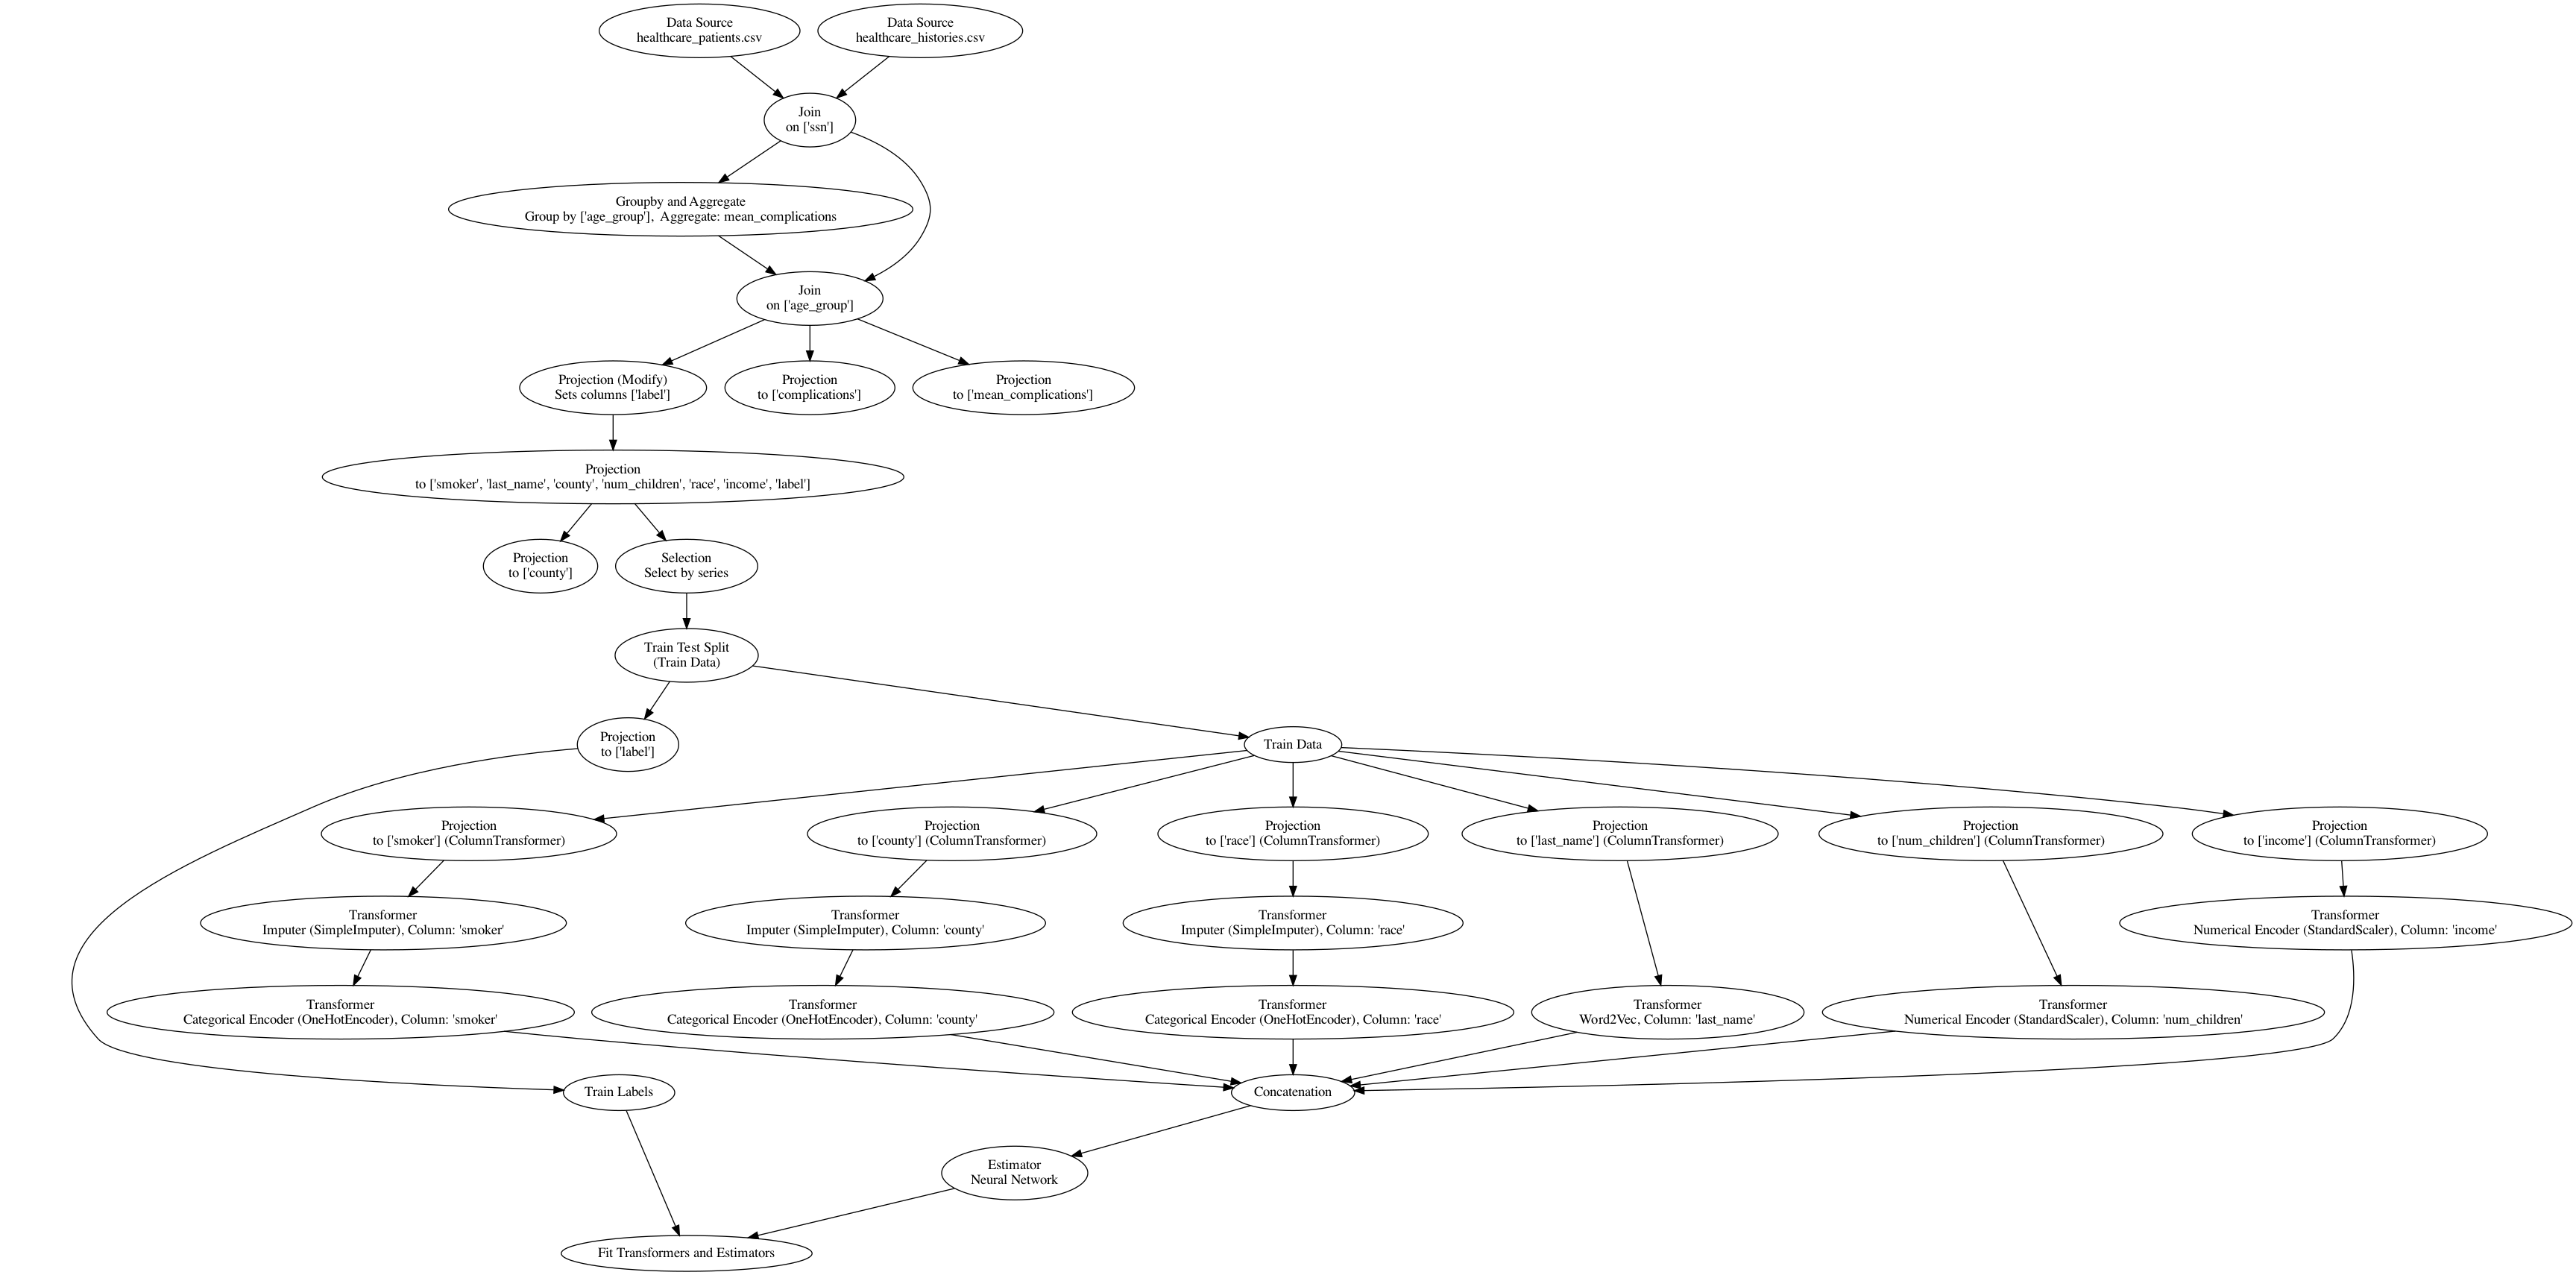

In [3]:
from IPython.display import Image

filename = os.path.join(str(get_project_root()), "demo", "healthcare", "healthcare.png")
save_fig_to_path(extracted_dag, filename)

Image(filename=filename) 

# Want to know the output of a specific operator?

For each operator, the `MaterializeFirstRowsInspection` materialized the first `5` output rows. Especially for scikit-learn pipelines, it requires custom debugging code if a user just wants to look at some intermediate results ([example stackoverflow post](https://stackoverflow.com/questions/34802465/sklearn-is-there-any-way-to-debug-pipelines)). Using mlinspect, this becomes easy. We can look at the input and output of arbitrary featurizers like OneHotEncoders or Word2Vec models. 

Here, we use this functionality to look at the output of a OneHotEncoder and the imputer right before it. For this, we only need to look at the inspection result for the corresponding Dag nodes. In this example, we can see that the OneHotEncoder encounters two different values for the `county` column in the train set. We see that the value `county2` gets transformed to `[1,0]` and `county3` gets transformed to `[0,1]`.

In [4]:
first_rows_inspection_result = inspection_results[MaterializeFirstRowsInspection(5)]

relevant_nodes = [node for node in extracted_dag.nodes if node.description in {
    "Imputer (SimpleImputer), Column: 'county'", "Categorical Encoder (OneHotEncoder), Column: 'county'"}]

for dag_node in relevant_nodes:
    if dag_node in first_rows_inspection_result and first_rows_inspection_result[dag_node] is not None:
        print('\033[1m')
        print(dag_node.operator_type, dag_node.code_reference, dag_node.module, dag_node.description, '\033[0m')
        print(first_rows_inspection_result[dag_node])


OperatorType.TRANSFORMER CodeReference(lineno=42, col_offset=19, end_lineno=42, end_col_offset=58) ('sklearn.impute._base', 'SimpleImputer', 'Pipeline') Imputer (SimpleImputer), Column: 'county' 
[InspectionInputRow(values=['county2'], fields=['array']), InspectionInputRow(values=['county2'], fields=['array']), InspectionInputRow(values=['county3'], fields=['array']), InspectionInputRow(values=['county3'], fields=['array']), InspectionInputRow(values=['county3'], fields=['array'])]

OperatorType.TRANSFORMER CodeReference(lineno=43, col_offset=19, end_lineno=43, end_col_offset=71) ('sklearn.preprocessing._encoders', 'OneHotEncoder', 'Pipeline') Categorical Encoder (OneHotEncoder), Column: 'county' 
[InspectionInputRow(values=[array([1., 0.])], fields=['array']), InspectionInputRow(values=[array([1., 0.])], fields=['array']), InspectionInputRow(values=[array([0., 1.])], fields=['array']), InspectionInputRow(values=[array([0., 1.])], fields=['array']), InspectionInputRow(values=[array([0

# Want to know the origin of some row in the featurised model input?

We can use the `LineageDemoInspection` to get row-level lineage information for e.g., a featurised tuple. In practice, you probably do not want to look at the lineage information yourself, as it can get quite complicated for complex pipelines like the one in our example. In the future, we could e.g., extend the lineage inspection to take a list of lineage ids and materialize all related intermediate results in the pipeline when the user re-executes the pipeline. This way, users do not have to interpret the lineage ids themselves.

Here, we use the functionality of the `LineageDemoInspection` to look at a featurised row from the train set that our neural network gets fitted on. We start by printing the first output row from the `DATA_SOURCE` and `GROUP_BY_AGG` operators. As we can see, the `LineageDemoInspection` generates unique identifiers for each of the rows when they get created. As these rows flow through the DAG, the lineage id annotations get propagated and combined at operators like `JOIN` and `CONCATENATION`. In our example, the `CONCATENATION` operator is the last one before the model training. By analysing the `Lineage` value for the first output row of the `CONCATENATION` operator, we can see how this featurised row originated from the data initally created by the `DATA_SOURCE` and `GROUP_BY_AGG` operators. When just looking at the `Value` of this featurised row, it is hard to find out that this output row is the feature vector for a patient with the name `Tabby Ward`. With our lineage information, this becomes much easier.

In [5]:
lineage_inspection_result = inspection_results[LineageDemoInspection(5)]

relevant_nodes = [node for node in extracted_dag.nodes if node.operator_type in {OperatorType.DATA_SOURCE, OperatorType.GROUP_BY_AGG, OperatorType.CONCATENATION}]

#print(lineage_inspection_result)
for dag_node in relevant_nodes:
    if dag_node in lineage_inspection_result: #and lineage_inspection_result[dag_node] is not None:
        print('\033[1m')
        print(dag_node.operator_type, dag_node.code_reference, dag_node.module, dag_node.description, '\033[0m')
        row = lineage_inspection_result[dag_node][0]
        print("First output row:")
        print("\033[1mLineage: \033[0m{}".format(row[0]))
        print("\033[1mValue: \033[0m{}".format(row[1]))


OperatorType.DATA_SOURCE CodeReference(lineno=19, col_offset=11, end_lineno=19, end_col_offset=125) ('pandas.io.parsers', 'read_csv') healthcare_patients.csv 
First output row:
Lineage: LineageId(operator_id=0, row_id=0)
Value: InspectionInputRow(values=[1, 'Tabby', 'Ward', 'race3', 'county3', 1, 212036, 'group3', '670-18-6875'], fields=['id', 'first_name', 'last_name', 'race', 'county', 'num_children', 'income', 'age_group', 'ssn'])

OperatorType.DATA_SOURCE CodeReference(lineno=20, col_offset=12, end_lineno=21, end_col_offset=38) ('pandas.io.parsers', 'read_csv') healthcare_histories.csv 
First output row:
Lineage: LineageId(operator_id=1, row_id=0)
Value: InspectionInputRow(values=[False, 2, '670-18-6875'], fields=['smoker', 'complications', 'ssn'])

OperatorType.GROUP_BY_AGG CodeReference(lineno=27, col_offset=16, end_lineno=27, end_col_offset=91) ('pandas.core.groupby.generic', 'agg') Group by ['age_group'],  Aggregate: mean_complications 
First output row:
Lineage: LineageId(ope

# What about issue 6? Were there missing embeddings?

For each operator in the DAG, `MissingEmbeddingInspection` checked if it is the Word2Vec transformer. Once it got to see the output rows for this transformer, it checked each output array if it is equal to the 0-vector. It it finds such values with missing embeddings, it remembers a few example rows (here: the first `20`) to help the user understand what is happening. 

Here, we only have to look at the output of the `MissingEmbeddingInspection` for the Word2Vec transformer Dag node. It shows us how many missing embeddings there were and a few example values for which no embeddings were found.

In [6]:
embedding_inspection_result = inspection_results[MissingEmbeddingInspection(20)]

for dag_node in extracted_dag.nodes:
    if dag_node in embedding_inspection_result and embedding_inspection_result[dag_node] is not None:
        print('\033[1m')
        print(dag_node.operator_type, dag_node.code_reference, dag_node.module, dag_node.description, '\033[0m')
        row = lineage_inspection_result[dag_node][0]
        op_result = embedding_inspection_result[dag_node]
        print("Number of missing embeddings: {}".format(op_result["missing_embedding_count"]))
        print("Example values with missing embeddings: {}".format(op_result["missing_embeddings_examples"]))
    


OperatorType.TRANSFORMER CodeReference(lineno=48, col_offset=17, end_lineno=48, end_col_offset=46) ('sklearn.demo.healthcare.demo_utils', 'MyW2VTransformer', 'Pipeline') Word2Vec, Column: 'last_name' 
Number of missing embeddings: 1
Example values with missing embeddings: ['VeryRareLastName']


**We found a missing embedding for a single rare name.**

# We can look at how histograms of sensitive groups change after different Dag nodes

Operators like joins, selections and missing value imputaters can cause *data distribution issues*, which can heavily impact the performance of our model. Mlinspect helps with identifying such issues by offering an inspection to calculate historams for sensitive groups. Thanks to our annotation propagation, this works even if the group columns are projected out at some point (**Issue 2**).

Before we look at the impact of different operators on the data distribution, we start by defining a function to plot the histograms before and after selected operators.

In [7]:
histogram_inspection_result = inspection_results[HistogramInspection()]

def print_dag_operator_histograms(before, after):
    print("Age_group histogram")

    plt.subplot(1, 2, 1)
    before_output_age_group = histogram_inspection_result[before]["age_group_counts"]
    plt.bar(before_output_age_group.keys(), before_output_age_group.values())
    plt.gca().set_title("before")

    plt.subplot(1, 2, 2)
    after_output_age_group = histogram_inspection_result[after]["age_group_counts"]
    plt.bar(after_output_age_group.keys(), after_output_age_group.values())
    plt.gca().set_title("after")
    
    fig = plt.gcf()
    fig.set_size_inches(12, 4)
    plt.show()
    
    print("Race histogram")
            
    plt.subplot(1, 2, 1)        
    before_output_race_group = histogram_inspection_result[before]["race_counts"]
    keys = [str(key) for key in before_output_race_group.keys()]
    plt.bar(keys, before_output_race_group.values())
    plt.gca().set_title("before")
   
    plt.subplot(1, 2, 2)
    after_output_race_group = histogram_inspection_result[after]["race_counts"]
    keys = [str(key) for key in after_output_race_group.keys()]
    plt.bar(keys, after_output_race_group.values())
    plt.gca().set_title("after")
    
    fig = plt.gcf()
    fig.set_size_inches(12, 4)
    plt.show()

## Issue 1: Join might change proportions of groups in data

We start by looking at the first operator that could heavily change the proportion of groups in our data, the join of the `patients` and `histories` datasets. E.g., there could be missing history entries for some patients, leading to many patients being filtered out.

Here, we start by finding the corresponding `JOIN` Dag node for the `merge` call and the operator before it. Then we use the plot function we defined before to compare the histograms before and after this join.

Age_group histogram


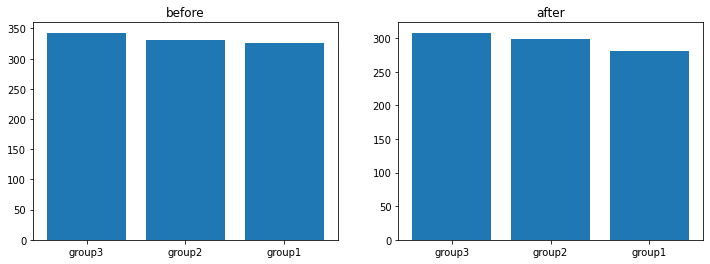

Race histogram


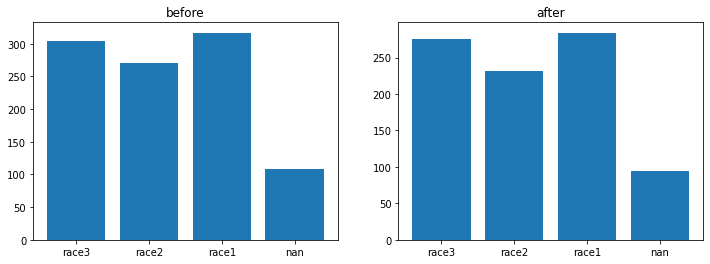

In [8]:
relevant_nodes = [node for node in extracted_dag.nodes if node.description in {
    "healthcare_patients.csv", "on ['ssn']"}]

print_dag_operator_histograms(relevant_nodes[0], relevant_nodes[1])

**As we can see, there are no noteworthy changes because of the join.**

## Issue 3: Selection might change proportions of groups in data

The next operator that could change the data distribution is the filter for patients in a few predefined counties. It could be that patients of different demographic groups are not uniformly distributed across different counties. It could, e.g., be that most of the patients with a specific `age_group` or `race` value live in a specific county.

Again, we need to find the Dag node corresponding to the code for the selection as well as the operator right before it. Then, we look at the histograms before and after.

Age_group histogram


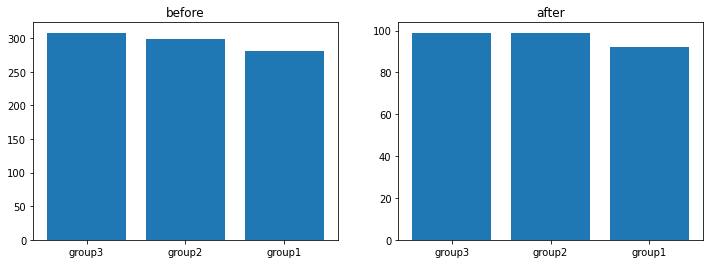

Race histogram


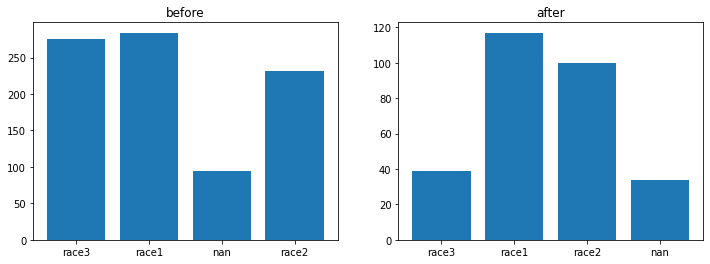

In [9]:
relevant_nodes = [node for node in extracted_dag.nodes if node.description in {
    "to ['smoker', 'last_name', 'county', 'num_children', 'race', 'income', 'label']", "Select by series"}]

print_dag_operator_histograms(relevant_nodes[0], relevant_nodes[1])

**There clearly is an issue here! A lot of values from the `race` `race3` are filtered out!** This is because a lot of patients with `race3` live in `county1` in our example.

## Issue 4: Imputation might change proportions of groups in data

The last operator that we want to look at that can change the distribution of sensitive groups is the missing value imputation for the `race` column. Depending on the imputation strategy, it can also introduce or amplify data distribution issues. It might attribute records with a missing value to the majority race in the dataset.

Again, we need to find the Dag node corresponding to the code for the imputation as well as the operator right before it. Then, we look at the histograms before and after.

Age_group histogram


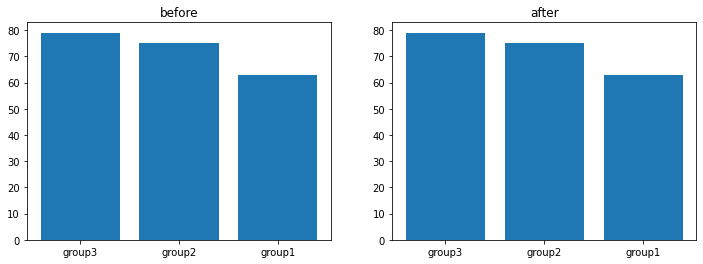

Race histogram


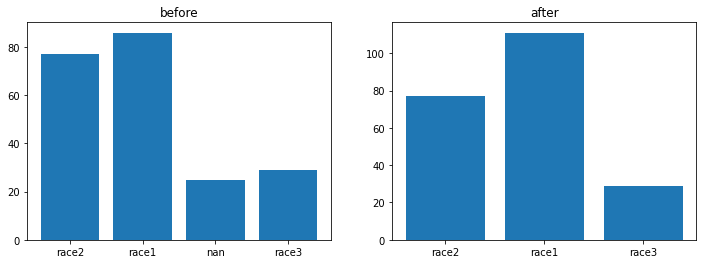

In [10]:
relevant_nodes = [node for node in extracted_dag.nodes if node.description in {
    "to ['race'] (ColumnTransformer)", "Imputer (SimpleImputer), Column: 'race'"}]

print_dag_operator_histograms(relevant_nodes[0], relevant_nodes[1])

**The `most-frequent` imputation amplifies the existing `race` imbalance!**